In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Sep 26 09:25:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Install dependencies

In [ ]:
!pip install -q roboflow maestro==0.2.0rc5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.3 MB/s eta 0:00:00


## Download dataset

In [ ]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

version = rf.workspace("roboflow-jvuqo").project("chartqa-6pz0e").version(1)
dataset = version.download("jsonl")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ChartQA-1 in jsonl:: 100%|██████████| 20826/20826 [00:03<00:00, 5802.45it/s]


In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"872a5b2feb73815d838ca904d22f16eb_png.rf.c67792c44387699b291a46d487675b86.jpg","prefix":"How many non-gaming apps were available in the App Store in 2020?","suffix":"3420161"}
{"image":"e0b0ab26790096d94b6d5c01c1f5a586_png.rf.c67cb9d929bebfde204ac7e08526e3fd.jpg","prefix":"What is the expected growth rate of the wearable mobile medical equipment market in China from 2015 to 2016?","suffix":"99.2"}
{"image":"c94129b94e922ee5841c90c06eab483d_png.rf.c67bb6d80c1d35b8a8628a14c2602485.jpg","prefix":"How many Croatian kunas were exported in 2017?","suffix":"73"}
{"image":"3a8cbc3e0c936447d2042bb1d2a39046_png.rf.c679b59d2a33750ddff1a10ee0cb6d8c.jpg","prefix":"What was the expected number of Facebook users in South Korea in 2025?","suffix":"16.1"}
{"image":"3a8cbc3e0c936447d2042bb1d2a39046_png.rf.c679b59d2a33750ddff1a10ee0cb6d8c.jpg","prefix":"How many people used Facebook in South Korea in 2019?","suffix":"15"}


**NOTE:** The downloaded dataset is in raw JSONL format. To remain consistent with the Florence-2 convention, we will prefix each prefix with the name of the vision task being performed. In our case, this will be `<VQA>`.

In [ ]:
import json
import os
from typing import Any


def modify_jsonl(file_path: str, task: str) -> None:
    """Modify each line of a JSONL file by prepending a task string to the 'prefix' value.

    Args:
        file_path (str): Path to the JSONL file to modify.
        task (str): The string to prepend to each 'prefix' value in the JSONL file.

    Returns:
        None
    """
    temp_file_path: str = file_path + ".temp"

    with open(file_path) as infile, open(temp_file_path, "w") as outfile:
        for line in infile:
            data: dict[str, Any] = json.loads(line.strip())
            data["prefix"] = f"{task}{data['prefix']}"
            outfile.write(json.dumps(data) + "\n")

    os.replace(temp_file_path, file_path)

In [ ]:
modify_jsonl(f"{dataset.location}/train/annotations.jsonl", "<VQA>")
modify_jsonl(f"{dataset.location}/test/annotations.jsonl", "<VQA>")
modify_jsonl(f"{dataset.location}/valid/annotations.jsonl", "<VQA>")

In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image": "872a5b2feb73815d838ca904d22f16eb_png.rf.c67792c44387699b291a46d487675b86.jpg", "prefix": "<VQA>How many non-gaming apps were available in the App Store in 2020?", "suffix": "3420161"}
{"image": "e0b0ab26790096d94b6d5c01c1f5a586_png.rf.c67cb9d929bebfde204ac7e08526e3fd.jpg", "prefix": "<VQA>What is the expected growth rate of the wearable mobile medical equipment market in China from 2015 to 2016?", "suffix": "99.2"}
{"image": "c94129b94e922ee5841c90c06eab483d_png.rf.c67bb6d80c1d35b8a8628a14c2602485.jpg", "prefix": "<VQA>How many Croatian kunas were exported in 2017?", "suffix": "73"}
{"image": "3a8cbc3e0c936447d2042bb1d2a39046_png.rf.c679b59d2a33750ddff1a10ee0cb6d8c.jpg", "prefix": "<VQA>What was the expected number of Facebook users in South Korea in 2025?", "suffix": "16.1"}
{"image": "3a8cbc3e0c936447d2042bb1d2a39046_png.rf.c679b59d2a33750ddff1a10ee0cb6d8c.jpg", "prefix": "<VQA>How many people used Facebook in South Korea in 2019?", "suffix": "15"}


## Fine-tune Florence-2 on visual questions answering (VQA) dataset

In [ ]:
!maestro florence2 train --help

                                                                                                    
 Usage: maestro florence2 train [OPTIONS]                                                           
                                                                                                    
 Train Florence 2 model                                                                             
                                                                                                    
╭─ Options ────────────────────────────────────────────────────────────────────────────────────────╮
│ *  --dataset                                 TEXT     Path to the dataset used for training      │
│                                                       [default: None]                            │
│                                                       [required]                                 │
│    --model_id                                TEXT     Identifier for the Florence-2 model

In [ ]:
!maestro florence2 train --dataset={dataset.location} \
--epochs=3 --batch_size=14 --lr=2e-6 \
--metrics word_error_rate --metrics character_error_rate

## Evaluate Florence-2 on visual questions answering (VQA) dataset

In [ ]:
!ls -la training/florence-2/1/metrics/

total 776
drwxr-xr-x 2 root root   4096 Sep 26 12:31 .
drwxr-xr-x 4 root root   4096 Sep 26 12:31 ..
-rw-r--r-- 1 root root  31661 Sep 26 12:31 cer_plot.png
-rw-r--r-- 1 root root  33816 Sep 26 12:31 loss_plot.png
-rw-r--r-- 1 root root 667912 Sep 26 12:31 training.json
-rw-r--r-- 1 root root   1030 Sep 26 12:31 validation.json
-rw-r--r-- 1 root root  38340 Sep 26 12:31 wer_plot.png


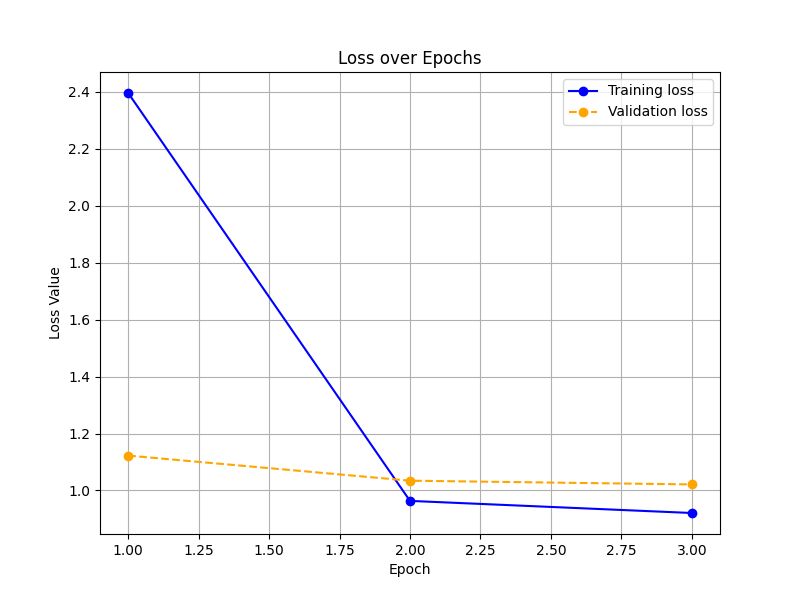

In [ ]:
from IPython.display import Image

Image(filename="training/florence-2/1/metrics/loss_plot.png", height=600)

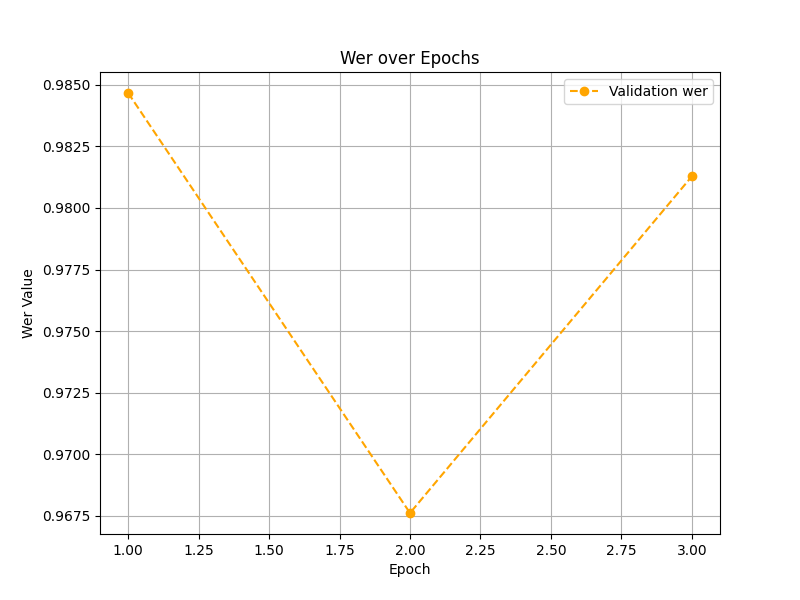

In [ ]:
from IPython.display import Image

Image(filename="training/florence-2/1/metrics/wer_plot.png", height=600)

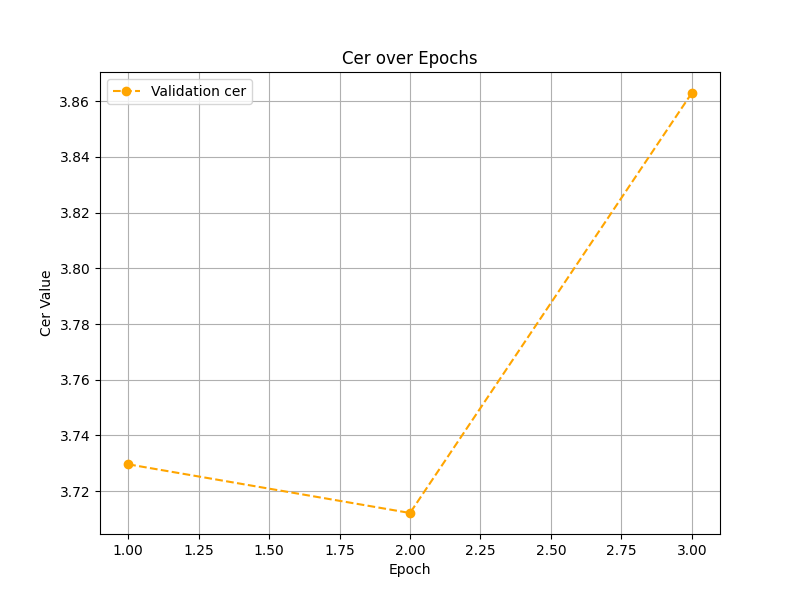

In [ ]:
from IPython.display import Image

Image(filename="training/florence-2/1/metrics/cer_plot.png", height=600)

In [ ]:
!ls -la training/florence-2/1/checkpoints/

total 16
drwxr-xr-x 4 root root 4096 Sep 26 10:30 .
drwxr-xr-x 4 root root 4096 Sep 26 12:31 ..
drwxr-xr-x 2 root root 4096 Sep 26 10:30 best
drwxr-xr-x 2 root root 4096 Sep 26 10:30 latest


In [ ]:
!maestro florence2 evaluate \
--dataset={dataset.location} \
--model_id=/content/training/florence-2/1/checkpoints/best \
--metrics word_error_rate --metrics character_error_rate

In [ ]:
!cat /content/evaluation/florence-2/metrics/evaluation.json

{
    "wer": [
        {
            "epoch": 1,
            "step": 1,
            "value": 0.9083285714285714
        }
    ],
    "cer": [
        {
            "epoch": 1,
            "step": 1,
            "value": 2.5642966056790737
        }
    ]
}

## Run inference

In [ ]:
from maestro.trainer.models.florence_2.checkpoints import load_model

processor, model = load_model(model_id_or_path="/content/training/florence-2/1/checkpoints/best")

In [ ]:
from maestro.trainer.common.data_loaders.datasets import JSONLDataset

ds = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/valid/annotations.jsonl", image_directory_path=f"{dataset.location}/valid/"
)

image, annotations = ds[0]
text = annotations["prefix"]

inputs = processor(text=text, images=image, return_tensors="pt").to("cuda")
generated_ids = model.generate(
    input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=1024, num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("question:", text)
print("answare:", generated_text)

question: <VQA>What company had a 21.2 percent share of the Indonesian mobile phone market in the first quarter of 2015?
answare: Samsung


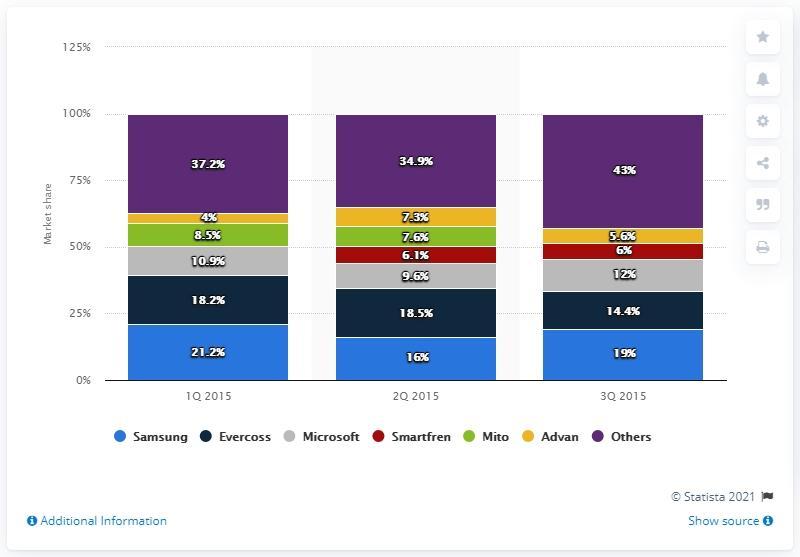

In [ ]:
image